## Deepchem DataLoader

In [1]:
from visar.deepchem_utils import prepare_dataset

RDKit WARNING: [21:23:26] Enabling RDKit 2019.09.1 jupyter extensions
/home/dqy14/miniconda3/envs/deepchem_visar/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/dqy14/miniconda3/envs/deepchem_visar/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dqy14/miniconda3/envs/deepchem_visar/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWa

In [2]:
para_dict_visar = {
    'model_name': 'baseline_reg',
    'task_list': ['T107'],
    'eval_type': 'regression',
    # input data related params:
    'dataset_file': './data/MT_data_clean_June28.csv',
    'feature_type': 'Circular_2048',
    'id_field': 'molregno',
    'smiles_field': 'salt_removed_smi',
    'model_flag': 'MT',
    'add_features': None,
    'frac_train': 0.8,
    'rand_seed': 0,
    # model architecture related parameters:
    'baseline_type': 'RidgeCV'
}

In [3]:
train_loader, test_loader, train_df, test_df = prepare_dataset(para_dict_visar)

/home/dqy14/miniconda3/envs/deepchem_visar/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (767) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Extracted dataset shape: (2951, 3)
Loading raw samples now.
shard_size: 8192
About to start loading CSV from tmp.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
TIMING: featurizing shard 0 took 14.519 s
TIMING: dataset construction took 14.705 s
Loading dataset from disk.
Computing train/valid/test indices
TIMING: dataset construction took 0.276 s
Loading dataset from disk.
TIMING: dataset construction took 0.135 s
Loading dataset from disk.


In [4]:
train_loader.X.shape, train_loader.y.shape, train_df.shape

((2360, 2048), (2360, 1), (2360, 3))

## baseline class

In [5]:
from visar.visar_utils import update_bicluster
from visar.VISAR_model import visar_model

In [6]:
baseline_model = visar_model(para_dict_visar)
baseline_model.model_init()
baseline_model.fit(train_loader)

In [7]:
print(baseline_model.model.coef_[0:10])

[ 0.          0.          0.01549756 -0.01746509 -0.02464854 -0.09164208
 -0.00728953  0.          0.01267765 -0.01952459]


In [8]:
baseline_model.generate_viz_results(train_loader, train_df, '/ridgeCV_')

------------- Prepare information for chemicals ------------------
------------- Prepare information for minibatches ------------------
------------- Prepare information for tasks ------------------
------- Generate color labels with default K of 5 --------
-------------- Saving datasets ----------------


In [9]:
baseline_model.generate_task_df()

In [10]:
SMILES_test = train_df[para_dict_visar['smiles_field']].iloc[0]
mol, _, _, atoms_contrib = baseline_model.generate_instance_analysis(smiles_string = SMILES_test)

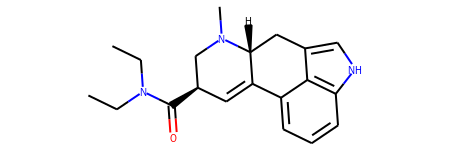

In [11]:
mol

## deepchem class

In [12]:
from visar.deepchem_regressor import deepchem_robust_regressor

In [13]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

para_dict_DC_robustMT = {
    'model_name': 'DC_RobustMT_reg',
    'task_list': ['T107', 'T108'],
    'eval_type': 'regression',
    # input data related params:
    'dataset_file': './data/MT_data_clean_June28.csv',
    'feature_type': 'Circular_2048',
    'id_field': 'molregno',
    'smiles_field': 'salt_removed_smi',
    'model_flag': 'MT',
    'add_features': None,
    'frac_train': 0.8,
    'rand_seed': 0,
    # model architecture related parameters:
    'layer_sizes': [128, 64],
    'bypass_layer_sizes': [64],
    'dropouts': 0.5,
    'bypass_dropouts': 0.5,
    # model training related parameters:
    'learning_rate': 0.001,
    'GPU': False,
    'epoch': 40, # training epoch of each round (saving model at the end of each round)
    'epoch_num': 2, # how many rounds
    # viz file processing related parameters:
    'valid_cutoff': None, 
    'n_layer': 2
}


In [14]:
train_loader, test_loader, train_df, test_df = prepare_dataset(para_dict_DC_robustMT)

/home/dqy14/miniconda3/envs/deepchem_visar/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (767) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Extracted dataset shape: (3471, 4)
Loading raw samples now.
shard_size: 8192
About to start loading CSV from tmp.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
TIMING: featurizing shard 0 took 17.686 s
TIMING: dataset construction took 17.898 s
Loading dataset from disk.
Computing train/valid/test indices
TIMING: dataset construction took 0.334 s
Loading dataset from disk.
TIMING: dataset construction took 0.154 s
Loading dataset from disk.


In [15]:
robust_model = deepchem_robust_regressor(para_dict_DC_robustMT)

In [16]:
robust_model.model_init()

In [ ]:
print(robust_model.__repr__())

In [ ]:
robust_model.fit(train_loader, test_loader, restore_flag = False)

In [17]:
prev_model = robust_model.save_path + '/model-1120'
robust_model.generate_viz_results(train_loader, train_df, 
                                  output_prefix = 'Robust_test', 
                                  prev_model = prev_model)

INFO:tensorflow:Restoring parameters from /home/dqy14/workplace/VISAR_workplace/logs/DC_RobustMT_reg/model/model-1120
------------- Prepare information for chemicals ------------------
------------- Prepare information for minibatches ------------------
------------- Prepare information for tasks ------------------
INFO:tensorflow:Restoring parameters from /home/dqy14/workplace/VISAR_workplace/logs/DC_RobustMT_reg/model/model-1120
INFO:tensorflow:Restoring parameters from /home/dqy14/workplace/VISAR_workplace/logs/DC_RobustMT_reg/model/model-1120
INFO:tensorflow:Restoring parameters from /home/dqy14/workplace/VISAR_workplace/logs/DC_RobustMT_reg/model/model-1120
------- Generate color labels with default K of 5 --------
-------------- Saving datasets ----------------


In [19]:
prev_model = robust_model.save_path + '/model-1120'
robust_model.load_model(prev_model)
robust_model.generate_task_df(train_loader, prev_model)

INFO:tensorflow:Restoring parameters from /home/dqy14/workplace/VISAR_workplace/logs/DC_RobustMT_reg/model/model-1120
INFO:tensorflow:Restoring parameters from /home/dqy14/workplace/VISAR_workplace/logs/DC_RobustMT_reg/model/model-1120
INFO:tensorflow:Restoring parameters from /home/dqy14/workplace/VISAR_workplace/logs/DC_RobustMT_reg/model/model-1120
INFO:tensorflow:Restoring parameters from /home/dqy14/workplace/VISAR_workplace/logs/DC_RobustMT_reg/model/model-1120


In [20]:
SMILES_test = train_df[para_dict_visar['smiles_field']].iloc[0]
mol, _, _, atoms_contrib = robust_model.generate_instance_analysis(smiles_string = SMILES_test)

In [23]:
atoms_contrib['T108']

array([[ -4.1959902 ],
       [ -5.42798206],
       [-10.63990976],
       [ -9.98688248],
       [ -7.24205565],
       [ -7.35544747],
       [ -7.52360559],
       [ -5.54949863],
       [ -5.36070129],
       [ -2.66119245],
       [ -2.43954856],
       [ -1.60418522],
       [ -5.09264268],
       [ -3.31626133],
       [ -4.44165734],
       [ -3.9726681 ]])

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

In [ ]:
print(help(deepchem_robust_regressor))